# Regressão Softmax com dados do MNIST

O objetivo deste notebook é ilustrar o uso do mesmo código matricial desenvolvido para a classificação das Flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.


## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [2]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

print("Amostras de treinamento:", x_train.size(0))
print("Amostras de teste:      ", x_test.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000
Amostras de teste:       10000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: 0 255
Tipo dos dados das imagens:         <class 'torch.ByteTensor'>
Tipo das classes das imagens:       <class 'torch.LongTensor'>


## Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras de teste.

In [3]:
x_train = x_train.float()
x_test = x_test.float()

x_train = x_train / 255.
x_test = x_test / 255.

if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

print("Amostras de treinamento:", x_train.size(0))
print("Amostras de teste:      ", x_test.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000
Amostras de teste:       500

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: 0.0 1.0
Tipo dos dados das imagens:         <class 'torch.FloatTensor'>
Tipo das classes das imagens:       <class 'torch.LongTensor'>


## Visualizando os dados

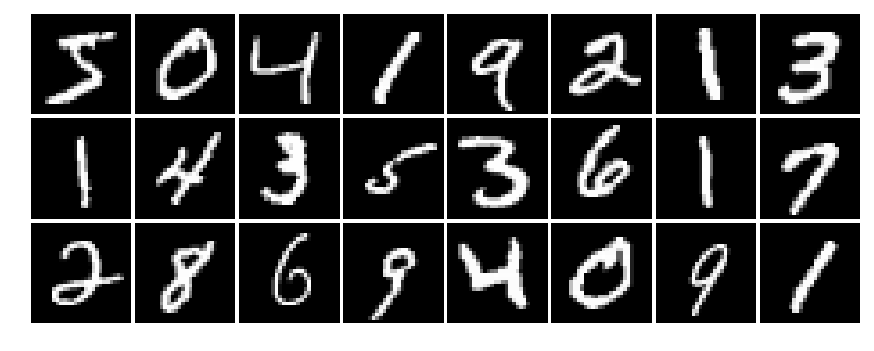

In [4]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Visualizando uma imagem com o matplotlib

class: 5


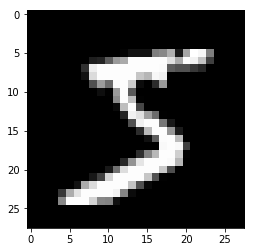

In [5]:
image = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Treinamento

### Inicialização dos parâmetros

In [6]:
epochs = 100
learningRate = 0.5

# Cria uma operação linear com entrada de tamanho 28*28 e saída com 10 neurônios (classes)
# O objeto criado armazenará os pesos
model = torch.nn.Linear(28*28, 10)

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss(size_average=True)
criterion2 = torch.nn.CrossEntropyLoss(size_average=False)

# Nosso otomizador será SDG
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos pesos

In [7]:
losses = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # calcula a saída da operação linear
    outputs = model(inputs)

    # calcula a perda
    targets = Variable(y_train)
    loss = criterion(outputs, targets)

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data[0])

In [8]:
print('Final loss:', loss.data[0])

Final loss: 0.26438453793525696


## Visualizando gráfico de perda durante o treinamento

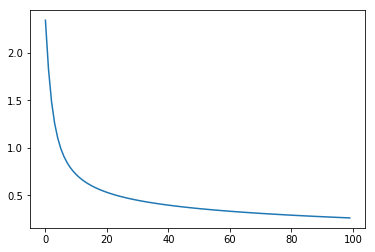

In [9]:
plt.plot(losses)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [10]:
def getAccuracy(model, input_data, targets):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = (predicts == targets).mean()
    return accuracy

print('Training Accuracy: ', getAccuracy(model, x_train.view(-1, 28*28), y_train))

print('Test Accuracy: ', getAccuracy(model, x_test.view(-1, 28*28), y_test))

Training Accuracy:  0.937
Test Accuracy:  0.858


## Matriz de confusão com dados de treinamento e teste

In [11]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

In [12]:
print('Matriz de confusão (treinamento):')
pd.crosstab(predict(model, x_train.view(-1, 28*28)), y_train.numpy())

Matriz de confusão (treinamento):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,2,0,0,0,2,3,1,0
2,0,1,90,2,0,1,0,1,2,1
3,0,0,0,87,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,4
8,0,2,2,0,0,2,0,0,82,0


In [13]:
print('Matriz de confusão (Teste):')
pd.crosstab(predict(model, x_test.view(-1, 28*28)), y_test.numpy())

Matriz de confusão (Teste):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,41,0,0,0,0,1,2,0,1,0
1,0,67,1,0,0,1,0,0,0,0
2,0,0,46,1,0,1,3,1,2,0
3,0,0,2,34,0,0,0,0,0,3
4,0,0,0,0,47,1,2,2,1,0
5,0,0,0,7,0,39,2,0,1,1
6,0,0,2,0,3,0,34,0,0,0
7,0,0,3,2,0,4,0,44,2,4
8,1,0,1,1,0,2,0,0,32,1


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


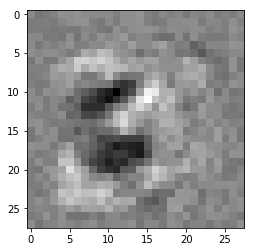

In [14]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

## Visualizando os pesos de todas as classes

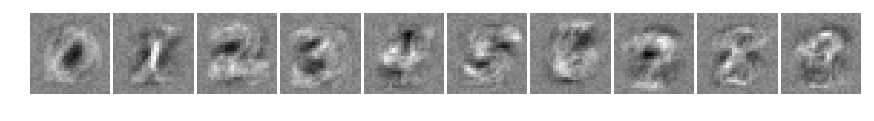

In [15]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Diagrama da regressão softmax com visualização dos pesos W

<img src="../figures/RegressaoSoftmaxArgmaxNMIST.png",width = 400>


# Atividades

## Exercícios

1. Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_oh_hat e o y_hat, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

class: 4


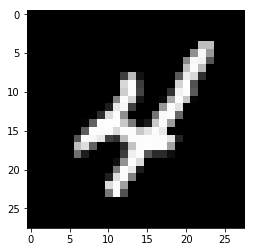

In [16]:
image = x_train[9]
target = y_train[9]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

2. Insira código no laço do treinamento para que no final de cada época, 
seja impresso: o número da época e a perda e a acurácia
3. Insira código no laço de treinamento para que seja impresso a contagem
de mini-batches ocorrida em cada época.

## Perguntas

1. Qual é o tamanho do mini-batch?
2. Em uma época, quantos mini-batches existem?
3. Por que no treino, a acurácia é 100%, mas no teste foi de 84,5%
4. Por que no treino, a acurácia é 100%, porém a função de perda final não é zero, mas sim 0,015 ?
5. O que se deve fazer para que a avaliação no conjunto de teste seja melhorado?

## Conclusões sobre os experimentos deste notebook
